# Fragment Filtering with Semaxis

Filter story fragments to keep only self-contained stories using semantic axis approach.

## Setup

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from config import PROCESSED_DATA_DIR

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [2]:
# Load fragments
fragments_path = PROCESSED_DATA_DIR / "ao3_fragments.csv"
df = pd.read_csv(fragments_path)
print(f"Loaded {len(df):,} fragments")
df.head()

Loaded 349,028 fragments


,id,text,word_count,emotion,emotion_score,nsfw,source_story_id,title,tag,tags,source,kudos,url
0,ao3_34500952_0,“I’ll take the protection assignment.” “Right-...,32,disgust,0.803,False,ao3_34500952,Draco Malfoy and the Mortifying Ordeal of Bein...,Humor,"['Healer Hermione Granger', 'Researcher Hermio...",ao3,93983,https://archiveofourown.org/works/34500952?vie...
1,ao3_34500952_1,Draco wondered when McGonagall had Apparated i...,21,surprise,0.851,False,ao3_34500952,Draco Malfoy and the Mortifying Ordeal of Bein...,Humor,"['Healer Hermione Granger', 'Researcher Hermio...",ao3,93983,https://archiveofourown.org/works/34500952?vie...
2,ao3_34500952_2,Granger had forsaken her Muggle clothing for g...,32,anger,0.928,False,ao3_34500952,Draco Malfoy and the Mortifying Ordeal of Bein...,Humor,"['Healer Hermione Granger', 'Researcher Hermio...",ao3,93983,https://archiveofourown.org/works/34500952?vie...
3,ao3_34500952_3,It’s all in the cloud.” “The cloud.” “Yes. I’d...,39,fear,0.840,False,ao3_34500952,Draco Malfoy and the Mortifying Ordeal of Bein...,Humor,"['Healer Hermione Granger', 'Researcher Hermio...",ao3,93983,https://archiveofourown.org/works/34500952?vie...
4,ao3_34500952_4,"“If I’m a baddie who needs information, what d...",25,fear,0.861,False,ao3_34500952,Draco Malfoy and the Mortifying Ordeal of Bein...,Humor,"['Healer Hermione Granger', 'Researcher Hermio...",ao3,93983,https://archiveofourown.org/works/34500952?vie...


## Sample Fragments for Labeling

Review random fragments and note their IDs in the lists below.

In [30]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# 100 random fragments for labeling
sample = df.sample(n=100, random_state=42)

sample[['id', 'text']].iloc[:11]

,id,text
342135,ao3_22038418_1038,"Any questions?"" Both Aizawas shake their heads, and with a slight smile, she shoos them out. ""Go on, off with you then. You'd better not be back in this school until Monday, either of you!""."
175992,ao3_29901264_167,"Nedzu had given him a pass so the gate wouldn’t lock him out, but other than that, had not given the boy directions. “It will be a fun puzzle! All you have to do is find my office!"
290915,ao3_39735819_534,An infamous muggleborn hater. To the person who tried to kill Albus Dumbledore.
94304,ao3_38714697_1266,"Everything felt bleary, like a picture coming into focus. He was tired, worn out, and sore, but seeing Charlie was like bringing everything back to reality. Charlie looked so pretty."
249735,ao3_29548224_68,"Castiel is just like he's always been around Dean. Knowing what heartbreak looks like, that'snotwhat Castiel is experiencing."
208596,ao3_44979484_7460,"“But I know they can match when people are in love.” “That’s not love, it's obsession,” Snape replied. “So you were obsessed with Lily Potter? What a shock,” Regulus replied. Snape rolled his eyes."
96337,ao3_20062966_26,"Crowley wyd EPISODE 17: [...] CROWLEY:Look, movie theaters aremeantto be snuck into! I would know, Iinventedthe overpriced cinema ticket, to encourage that sort of thing! AZIRAPHALE:I shudder to ask when the last time you actuallypaidto see a film was, Crowley."
245403,ao3_25085842_1104,Shen Yuan noticed a hint of red glowing in his eyes. Uh oh.
303050,ao3_19042240_957,"His breath scorched Harry’s face. “I didn’t want it to be like this, I was certain that you wouldn’t remember anything, but since it no longer matters — yes."
143369,ao3_453579_399,"He knew, objectively, that Scott was hot, but seeing all three of them all...shirtless and...sweaty and...angry... ""Holy Homoerotic Hotties, Batman."" And suddenly they were all turning to stare at him. Stiles closed his eyes protectively."


In [79]:
# need more self contained examples 
sample2 = df.sample(n=300, random_state=102)

sample2[['id', 'text']].iloc[281:291]

,id,text
64718,ao3_34816549_3511,"And… Ling Wen’s eyes widen with shock, and she’s so thrown off—she forgets to speak into the communication array. “No…” She mutters, her brow creasing as she struggles to decipher those eyes."
83933,ao3_32163913_1124,"Izuku finds it crazy how many more places he knew now because of Katsuki. Finally, Izuku bends down to pick up one mid-sized pebble and holds it in his palms. He looks out onto the view and thinks."
52742,ao3_5293532_204,He probably didn’t expect Jimin to spin it into a twisted stretch of fabric like a rope and then started knotting it around one of his wrists. When he saw what he was doing Taehyung made a surprised noise.
178403,ao3_1417834_1449,"Stay still,"" and he suddenly sat up, leaning up toward Dean, grabbing Dean's upper body with both arms, pinning Dean's arms to his sides. Dean felt him shudder. There was ahugecrack of thunder overhead. Clouds suddenly boiling overhead."
211257,ao3_6145074_527,"Anya began to protest, but theSkayonclearly already had an argument prepared, and she launched into it immediately. ""If they find out you're really an alpha, you're done for anyway, right?"" Anya nodded."
36241,ao3_11985126_898,"Tony had matured so suddenly, it was overwhelming to comprehend. Some days, Pepper would still wake up and question the absurdity of the past year. Her boss, her Tony, was Iron Man: a superhero and symbol of the free world."
5218,ao3_30153540_2829,Barbara (03:15am):He removed all of his trackers. They just spell ‘fuck you’ now. Barbara (03:15am):I can send you a general area. Bruce (03:16am):On my way.
244518,ao3_25085842_219,"""He also fucking left me so shut up!"" Shen Yuan flinched a little."
256622,ao3_11781915_558,"Reaching up, he now gently presses his fingers against Will’s chest before skimming his lips against the same spot. “You’re a courageous boy aren’t you?” he adds. “See how wary and unsure you are – yet here you stay."
175207,ao3_29088369_735,"Izuku thinks back to what Recovery Girl told him about quirk overuse. He supposes that would only apply to emitter-type quirks, but he wonders what would happen if one of Shoji’s extra limbs were cut off. Would it grow back?"


## Manual Labels

After reviewing above, add IDs to these lists:

In [80]:
# Add fragment IDs here after reviewing
self_contained_ids = [
    # IDs of self-contained stories
    "ao3_38714697_1266",
    "ao3_29548224_68",
    "ao3_44979484_7460",
    "ao3_20062966_26",
    "ao3_25085842_1104",
    "ao3_19042240_957",
    "ao3_453579_399",
    "ao3_25085842_2119",
    "ao3_40307019_350",
    "ao3_1117942_1950",
    "ao3_34259563_35",
    "ao3_19724044_34",
    "ao3_53634157_594",
    "ao3_15146219_296",
    "ao3_34816549_11489",
    "ao3_34500952_1802",
    "ao3_5363684_3751",
    "ao3_20463974_1161",
    "ao3_26364097_3644",
    "ao3_8245553_50",
    "ao3_34816549_5796",
    "ao3_23026369_505",
    "ao3_3171550_1025",
    "ao3_25757818_397",
    "ao3_39597543_181",
    "ao3_3592992_50",
    "ao3_47193232_33",
    "ao3_46351063_1318",
    "ao3_25588000_200",
    "ao3_22942099_1001",
    "ao3_28777140_1078",
    "ao3_17946929_680",
    "ao3_26364097_3487",
    "ao3_14707098_307",
    "ao3_30812927_339",
    "ao3_39842187_1054",
    "ao3_22942099_4237",
    "ao3_39492981_821",
    "ao3_7127210_1509",
    "ao3_30349320_2155",
    "ao3_4034197_624",
    "ao3_25085842_1699",
    "ao3_30652973_2799",
    "ao3_8738770_185", 
    "ao3_34816549_381", 
    "ao3_42084009_583", 
    "ao3_24376396_381", 
    "ao3_26364097_2659",
    "ao3_22942099_2467",
    "ao3_40146012_217",
    "ao3_32163913_1448",
    "ao3_28777140_5256"
]

fragmented_ids = [
    # IDs of fragmented/mid-conversation snippets 
    "ao3_22038418_1038",
    "ao3_29901264_167",
    "ao3_39735819_534",
    "ao3_8909155_25",
    "ao3_32163913_1712",
    "ao3_30812927_403",
    "ao3_42910668_42",
    "ao3_10643571_3347",
    "ao3_46351063_450",
    "ao3_26523892_6249",
    "ao3_25588000_531",
    "ao3_34816549_11384",
    "ao3_34577035_1813",
    "ao3_53735629_372",
    "ao3_16392173_9244",
    "ao3_35515399_961",
    "ao3_1046159_0",
    "ao3_34577035_3176",
    "ao3_53813671_452",
    "ao3_52884502_85",
    "ao3_16392173_5400",
    "ao3_26523892_3270",
    "ao3_8300672_434",
    "ao3_234222_167",
    "ao3_19334392_2533",
    "ao3_41199483_1082",
    "ao3_34816549_12520",
    "ao3_26364097_9398",
    "ao3_12805206_2467",
    "ao3_24773944_381",
    "ao3_10588629_590",
    "ao3_34816549_9088",
    "ao3_19110040_494",
    "ao3_30349320_317",
    "ao3_34586890_1637",
    "ao3_1035300_404",
    "ao3_34500952_1530",
    "ao3_30153540_578",
    "ao3_17946929_972",
    "ao3_24273403_18",
    "ao3_25085842_1460",
    "ao3_16392173_2172",
    "ao3_30349320_3467",
    "ao3_50510668_1660",
    "ao3_10643571_3306",
    "ao3_12025527_792",
    "ao3_7569610_32",
    "ao3_30547047_326",
    "ao3_12402426_841",
    "ao3_34577035_3451",
    "ao3_34816549_502",
    "ao3_1117942_3618",
    "ao3_44979484_1886",
    "ao3_41199483_74",
    "ao3_34816549_5124",
    "ao3_44979484_8135",
    "ao3_13867242_364"
]

print(f"Self-contained: {len(self_contained_ids)}")
print(f"Fragmentary: {len(fragmented_ids)}")

Self-contained: 52
Fragmentary: 57


## Load Embedding Model

In [81]:
print("Loading sentence-transformers model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Model loaded")

Loading sentence-transformers model...
✓ Model loaded


## Generate Embeddings for Labeled Fragments

In [82]:
# Get text for labeled fragments
self_contained_texts = df[df['id'].isin(self_contained_ids)]['text'].tolist()
fragmented_texts = df[df['id'].isin(fragmented_ids)]['text'].tolist()

print(f"Embedding {len(self_contained_texts)} self-contained fragments...")
self_contained_embeddings = model.encode(self_contained_texts, show_progress_bar=True)

print(f"Embedding {len(fragmented_texts)} fragmentary fragments...")
fragmented_embeddings = model.encode(fragmented_texts, show_progress_bar=True)

print("✓ Embeddings generated")

Embedding 52 self-contained fragments...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Embedding 57 fragmentary fragments...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Embeddings generated


## Compute Semaxis

In [83]:
# Average embeddings for each category
self_contained_avg = np.mean(self_contained_embeddings, axis=0)
fragmented_avg = np.mean(fragmented_embeddings, axis=0)

# Compute semantic axis
semaxis = self_contained_avg - fragmented_avg

print(f"Semaxis shape: {semaxis.shape}")
print(f"Semaxis magnitude: {np.linalg.norm(semaxis):.4f}")
print("✓ Semaxis computed")

Semaxis shape: (384,)
Semaxis magnitude: 0.2170
✓ Semaxis computed


## Generate Embeddings for ALL Fragments

This will take ~30 minutes for 349k fragments.

In [84]:
print(f"Embedding all {len(df):,} fragments...")
print("This will take ~30 minutes. Go get coffee!")

all_embeddings = model.encode(df['text'].tolist(), 
                               batch_size=256,
                               show_progress_bar=True)

print(f"✓ All embeddings generated: {all_embeddings.shape}")

Embedding all 349,028 fragments...
This will take ~30 minutes. Go get coffee!


Batches:   0%|          | 0/1364 [00:00<?, ?it/s]

✓ All embeddings generated: (349028, 384)


## Score All Fragments

In [85]:
# Compute cosine similarity with semaxis for each fragment
print("Computing scores...")
scores = cosine_similarity(all_embeddings, semaxis.reshape(1, -1)).flatten()

# Add scores to dataframe
df['semaxis_score'] = scores

print(f"✓ Scores computed")
print(f"Score range: {scores.min():.4f} to {scores.max():.4f}")
print(f"Mean score: {scores.mean():.4f}")
print(f"Median score: {np.median(scores):.4f}")

Computing scores...
✓ Scores computed
Score range: -0.3687 to 0.3756
Mean score: -0.0249
Median score: -0.0306


## Visualize Score Distribution

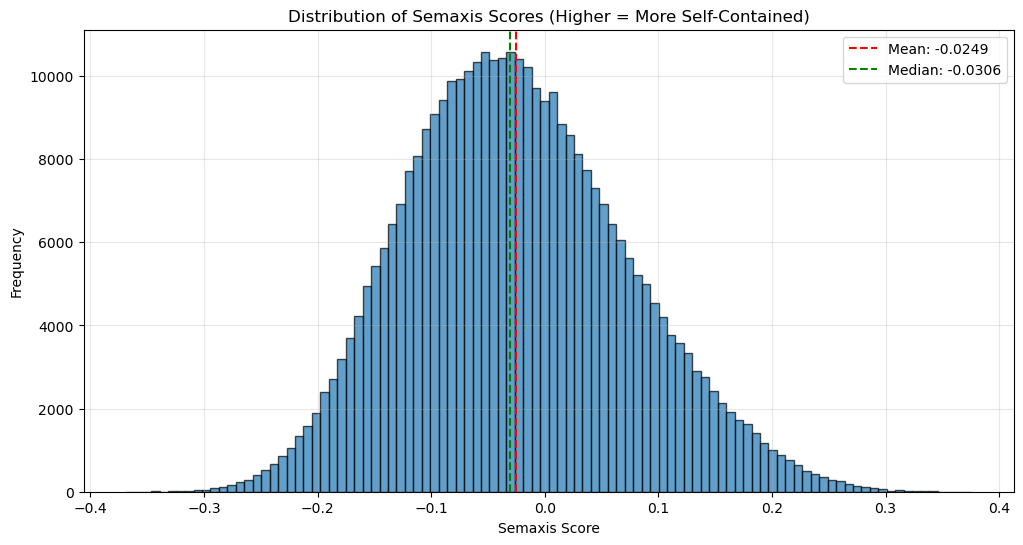

In [86]:
plt.figure(figsize=(12, 6))
plt.hist(scores, bins=100, alpha=0.7, edgecolor='black')
plt.axvline(scores.mean(), color='red', linestyle='--', label=f'Mean: {scores.mean():.4f}')
plt.axvline(np.median(scores), color='green', linestyle='--', label=f'Median: {np.median(scores):.4f}')
plt.xlabel('Semaxis Score')
plt.ylabel('Frequency')
plt.title('Distribution of Semaxis Scores (Higher = More Self-Contained)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Check Labeled Fragments' Scores

Self-contained fragments:
  Mean: 0.0964
  Range: -0.1400 to 0.2606

Fragmentary fragments:
  Mean: -0.1206
  Range: -0.3014 to 0.1545


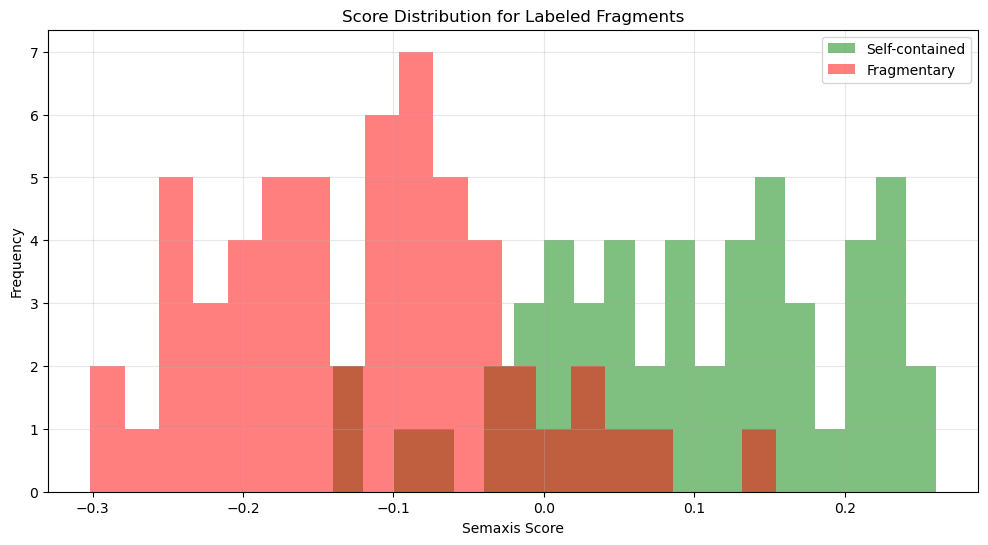

In [87]:
# See what scores your labeled fragments got
self_contained_scores = df[df['id'].isin(self_contained_ids)]['semaxis_score']
fragmented_scores = df[df['id'].isin(fragmented_ids)]['semaxis_score']

print("Self-contained fragments:")
print(f"  Mean: {self_contained_scores.mean():.4f}")
print(f"  Range: {self_contained_scores.min():.4f} to {self_contained_scores.max():.4f}")

print("\nFragmentary fragments:")
print(f"  Mean: {fragmented_scores.mean():.4f}")
print(f"  Range: {fragmented_scores.min():.4f} to {fragmented_scores.max():.4f}")

# Plot distributions
plt.figure(figsize=(12, 6))
plt.hist(self_contained_scores, bins=20, alpha=0.5, label='Self-contained', color='green')
plt.hist(fragmented_scores, bins=20, alpha=0.5, label='Fragmentary', color='red')
plt.xlabel('Semaxis Score')
plt.ylabel('Frequency')
plt.title('Score Distribution for Labeled Fragments')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Choose Threshold and Filter

Pick a threshold based on the distributions above. Higher threshold = fewer but higher quality fragments.

In [89]:
# Try different thresholds
thresholds = [-0.1, -0.05, 0.0, 0.05, 0.1, 0.15]

print("Threshold analysis:")
for threshold in thresholds:
    kept = (df['semaxis_score'] >= threshold).sum()
    pct = kept / len(df) * 100
    print(f"  {threshold:.1f}: {kept:,} fragments kept ({pct:.1f}%)")

Threshold analysis:
  -0.1: 268,331 fragments kept (76.9%)
  -0.1: 201,760 fragments kept (57.8%)
  0.0: 133,043 fragments kept (38.1%)
  0.1: 76,668 fragments kept (22.0%)
  0.1: 38,852 fragments kept (11.1%)
  0.1: 16,497 fragments kept (4.7%)


In [101]:
# Set your chosen threshold here
THRESHOLD = 0.0  # Adjust based on analysis above

# Filter fragments
filtered_df = df[df['semaxis_score'] >= THRESHOLD].copy()

print(f"Original: {len(df):,} fragments")
print(f"Filtered: {len(filtered_df):,} fragments ({len(filtered_df)/len(df)*100:.1f}%)")
print(f"Removed: {len(df) - len(filtered_df):,} fragments")

Original: 349,028 fragments
Filtered: 133,043 fragments (38.1%)
Removed: 215,985 fragments


## Sample Review of Filtered Fragments

In [106]:
filtered_df_sorted = filtered_df.sort_values(by='semaxis_score', ascending=False)

for idx, row in filtered_df_sorted.iloc[:50].iterrows():
    print(f"\nScore: {row['semaxis_score']:.4f}, NSFW: {row['nsfw']}")
    print(f"Text: {row['text']}")
    print("-" * 80)


Score: 0.3756, NSFW: True
Text: Eddie watched with a fond but bemused expression. Steve moved to Eddie’s chest, caressing him as he kissed down his body.
--------------------------------------------------------------------------------

Score: 0.3742, NSFW: True
Text: His eyes were deep and fathomless, gaze more intense than it had ever been when levelled against Eddie. Eddie swallowed. He wet his mouth and watched Steve’s eyes dip, tracking the movement.
--------------------------------------------------------------------------------

Score: 0.3709, NSFW: True
Text: Steve was looking at him now, his eyes wide in Eddie’s peripheral. He couldn’t stomach seeing his face, no matter what it wore.
--------------------------------------------------------------------------------

Score: 0.3551, NSFW: False
Text: When Eddie glanced at him, Steve looked more settled. Still relatively uncomfortable — his eyes kept lingering on Eddie’s throat, and on his blood-caked upper lip — but better.
------

## Save Filtered Fragments

In [104]:
# Save filtered fragments
output_path = PROCESSED_DATA_DIR / "ao3_fragments_selfcontained.csv"

filtered_df_sorted.to_csv(output_path, index=False)
print(f"✓ Saved {len(filtered_df):,} filtered fragments to {output_path}")

✓ Saved 133,043 filtered fragments to /Users/averylee/Desktop/Fiction Unlimited/notebooks/../data/processed/ao3_fragments_selfcontained.csv


## Statistics

In [105]:
print("\nFinal Statistics:")
print(f"Original fragments: {len(df):,}")
print(f"Filtered fragments: {len(filtered_df):,}")
print(f"Retention rate: {len(filtered_df)/len(df)*100:.1f}%")
print(f"\nEmotion distribution in filtered data:")
print(filtered_df['emotion'].value_counts())
print(f"\nNSFW distribution in filtered data:")
print(filtered_df['nsfw'].value_counts())


Final Statistics:
Original fragments: 349,028
Filtered fragments: 133,043
Retention rate: 38.1%

Emotion distribution in filtered data:
emotion
fear        36697
disgust     34111
surprise    21610
anger       18624
joy         12375
sadness      9626
Name: count, dtype: int64

NSFW distribution in filtered data:
nsfw
False    85734
True     47309
Name: count, dtype: int64


## Sentiment Shift 

In [ ]:
# import pandas as pd 

# filtered_df_sorted = pd.read_csv(PROCESSED_DATA_DIR / "ao3_fragments_selfcontained.csv")

In [15]:
len(filtered_df_sorted)

133043

In [7]:
# from transformers import pipeline

# sentiment = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

Device set to use mps:0


In [ ]:
# for idx, row in filtered_df_sorted.sample(50).iterrows():
#     # Split fragment in half
#     fragment = row['text']
#     words = fragment.split()
#     first_half = ' '.join(words[:2*len(words)//3])
#     second_half = ' '.join(words[2*len(words)//3:])

#     # Compare sentiment
#     sent1 = sentiment(first_half)[0]
#     sent2 = sentiment(second_half)[0]

#     # Twist if sentiment flips or confidence changes dramatically
#     has_twist = (sent1['label'] != sent2['label']) or \
#                 (abs(sent1['score'] - sent2['score']) > 0.4)
    
#     print(f"(twist: {has_twist}): {sent1['label']} {sent2['label']}")
#     print(fragment)
#     print()

(twist: False): NEGATIVE NEGATIVE
Barty has a hand on one of the horses, his head angled towards the ground so that Evan can’t really see his face properly. Which, now that he thinks about it, is a bit odd.

(twist: False): NEGATIVE NEGATIVE
When the ground stops shaking, McCree looks up to see Lúcio whizzing past with his Crossfade suit thumping. “Gandalf, baby!

(twist: True): NEGATIVE POSITIVE
Genuine. Hermione settled on her knees next to Scorpius as he studied his mother's face with the slow drag of his fingers. And then he placed his hands over his heart.

(twist: True): POSITIVE NEGATIVE
Clearly she’s bright enough to figure them out on her own. I’m shocked it’s taken this long actually.” Lucius leaned forward again, eyes narrowing. Draco fought the urge to squirm under his stare.

(twist: True): POSITIVE NEGATIVE
“Wow,” Hana gawks. “Whathappenedto him?” “He looksbeat up,” Lúcio mutters. “Check out the contusions on the brow bone and jaw.

(twist: True): POSITIVE NEGATIVE
Cranin